# 🔁 Full Workflow: Bayesian Decay Analysis with Bateman Matching

## 📥 Step 1: Load and Clean Histogram Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import aesara.tensor as at
# Load the tab-separated file
df = pd.read_csv("hist_33Na.csv")
df.head()

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


,BinCenter,BinContent
0,-99.75,2619
1,-99.25,2618
2,-98.75,2544
3,-98.25,2574
4,-97.75,2656


## 📊 Step 2: Rebin the Histogram

In [2]:
# Compute original bin width
diffs = df["BinCenter"].diff().dropna().unique()
bin_width = round(diffs[0], 5)
print(f"Original bin width: {bin_width} ms")

# Set desired bin width (user can modify this value)
desired_bin_width = 2
rebin_factor = int(desired_bin_width / bin_width)

if len(df) % rebin_factor != 0:
    df = df.iloc[:-(len(df) % rebin_factor)]

# Rebin data
df_rebinned = df.groupby(np.arange(len(df)) // rebin_factor).agg({
    "BinCenter": "mean",
    "BinContent": "sum",
}).reset_index(drop=True)

df_rebinned.head()

Original bin width: 0.5 ms


,BinCenter,BinContent
0,-99.0,10355
1,-97.0,10607
2,-95.0,10355
3,-93.0,10352
4,-91.0,10354


In [3]:
import pandas as pd

def parent(t_parent, a0, x):
    return a0*(np.exp(-((np.log(2))/t_parent)*x));
    
def daughter0n(t_daugh0n, t_parent, a0, branch0n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh0n):
        return a0*(branch0n)*(((np.log(2))/t_daugh0n)/(((np.log(2))/t_daugh0n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh0n)*x)))
    else:
        return a0*(branch0n)*(((np.log(2))/t_daugh0n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh0n)*x)))

def daughter1n(t_daugh1n, t_parent, a0, branch1n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh1n):
        return a0*(branch1n)*(((np.log(2))/t_daugh1n)/(((np.log(2))/t_daugh1n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh1n)*x)))
    else:
        return a0*(branch1n)*(((np.log(2))/t_daugh1n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh1n)*x)))

def daughter2n(t_daugh2n, t_parent, a0, branch2n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh2n):
        return a0*(branch2n)*(((np.log(2))/t_daugh2n)/(((np.log(2))/t_daugh2n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh2n)*x)))
    else:
        return a0*(branch2n)*(((np.log(2))/t_daugh2n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh2n)*x)))

def daughter3n(t_daugh3n, t_parent, a0, branch3n, x):
    if (np.log(2)/t_parent) != (np.log(2)/t_daugh3n):
        return a0*(branch3n)*(((np.log(2))/t_daugh3n)/(((np.log(2))/t_daugh3n) - ((np.log(2))/t_parent)))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh3n)*x)))
    else:
        return a0*(branch3n)*(((np.log(2))/t_daugh3n)/(0.0000001))*((np.exp(-((np.log(2))/t_parent)*x)) - (np.exp(-((np.log(2))/t_daugh3n)*x)))

def background(bkg, x):
    return bkg

def parentDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + background(bkg, x)

def parent1nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + background(bkg, x)

def parent2nDaughterLineararr(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, branch0n, branch1n, branch2n, bkg_arr, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + bkg_arr

def parent2nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, branch0n, branch1n, branch2n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + bkg

def parent3nDaughterLinear(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n, branch0n, branch1n, branch2n, branch3n, bkg, x):
    return parent(t_parent, a0, x) + daughter0n(t_daugh0n, t_parent, a0, branch0n, x) + daughter1n(t_daugh1n, t_parent, a0, branch1n, x) + daughter2n(t_daugh2n, t_parent, a0, branch2n, x) + daughter3n(t_daugh3n, t_parent, a0, branch3n, x) + background(bkg, x)


In [9]:
# %% Modified Bateman model (bin-integrated) with the SAME format/signature pattern
# We only add a final argument `binw` (bin width in ms).
import numpy as np
import aesara.tensor as at

ln2 = np.log(2.0)

# ---------- NumPy helpers (for quick checks/plots outside PyMC) ----------
def _int_exp_np(lmbda, t1, t2):
    return (np.exp(-lmbda * t1) - np.exp(-lmbda * t2)) / lmbda

def parent_mod(t_parent, a0, x, binw):
    lam_p = ln2 / t_parent
    t1, t2 = x - 0.5*binw, x + 0.5*binw
    return a0 * _int_exp_np(lam_p, t1, t2)

def _daughter_int_np(t_d, t_parent, a0, br, x, binw):
    lam_p = ln2 / t_parent
    lam_d = ln2 / t_d
    t1, t2 = x - 0.5*binw, x + 0.5*binw
    eps = 1e-12
    denom = (lam_d - lam_p) if abs(lam_d - lam_p) >= eps else np.sign(lam_d - lam_p)*eps
    coeff = a0 * br * (lam_d/denom)
    return coeff * (_int_exp_np(lam_p, t1, t2) - _int_exp_np(lam_d, t1, t2))

def daughter0n_mod(t_daugh0n, t_parent, a0, branch0n, x, binw):
    return _daughter_int_np(t_daugh0n, t_parent, a0, branch0n, x, binw)

def daughter1n_mod(t_daugh1n, t_parent, a0, branch1n, x, binw):
    return _daughter_int_np(t_daugh1n, t_parent, a0, branch1n, x, binw)

def daughter2n_mod(t_daugh2n, t_parent, a0, branch2n, x, binw):
    return _daughter_int_np(t_daugh2n, t_parent, a0, branch2n, x, binw)

def daughter3n_mod(t_daugh3n, t_parent, a0, branch3n, x, binw):
    return _daughter_int_np(t_daugh3n, t_parent, a0, branch3n, x, binw)

def background_mod(bkg_rate, x, binw):
    # bkg_rate in counts/ms → integrated per bin
    return bkg_rate * binw

def parentDaughterLinear_mod(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg_rate, x, binw):
    return (parent_mod(t_parent, a0, x, binw)
            + daughter0n_mod(t_daugh0n, t_parent, a0, branch0n, x, binw)
            + background_mod(bkg_rate, x, binw))

def parent1nDaughterLinear_mod(a0, t_parent, t_daugh0n, t_daugh1n, branch0n, branch1n, bkg_rate, x, binw):
    return (parent_mod(t_parent, a0, x, binw)
            + daughter0n_mod(t_daugh0n, t_parent, a0, branch0n, x, binw)
            + daughter1n_mod(t_daugh1n, t_parent, a0, branch1n, x, binw)
            + background_mod(bkg_rate, x, binw))

def parent2nDaughterLineararr_mod(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n,
                                  branch0n, branch1n, branch2n, bkg_arr_counts, x, binw):
    # Here bkg_arr is already per-bin COUNTS (integrated), so just add it
    return (parent_mod(t_parent, a0, x, binw)
            + daughter0n_mod(t_daugh0n, t_parent, a0, branch0n, x, binw)
            + daughter1n_mod(t_daugh1n, t_parent, a0, branch1n, x, binw)
            + daughter2n_mod(t_daugh2n, t_parent, a0, branch2n, x, binw)
            + bkg_arr_counts)

def parent2nDaughterLinear_mod(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n,
                               branch0n, branch1n, branch2n, bkg_rate, x, binw):
    return (parent_mod(t_parent, a0, x, binw)
            + daughter0n_mod(t_daugh0n, t_parent, a0, branch0n, x, binw)
            + daughter1n_mod(t_daugh1n, t_parent, a0, branch1n, x, binw)
            + daughter2n_mod(t_daugh2n, t_parent, a0, branch2n, x, binw)
            + background_mod(bkg_rate, x, binw))

def parent3nDaughterLinear_mod(a0, t_parent, t_daugh0n, t_daugh1n, t_daugh2n, t_daugh3n,
                               branch0n, branch1n, branch2n, branch3n, bkg_rate, x, binw):
    return (parent_mod(t_parent, a0, x, binw)
            + daughter0n_mod(t_daugh0n, t_parent, a0, branch0n, x, binw)
            + daughter1n_mod(t_daugh1n, t_parent, a0, branch1n, x, binw)
            + daughter2n_mod(t_daugh2n, t_parent, a0, branch2n, x, binw)
            + daughter3n_mod(t_daugh3n, t_parent, a0, branch3n, x, binw)
            + background_mod(bkg_rate, x, binw))

# ---------- Aesara helpers (for PyMC inside the graph) ----------
def _int_exp_at(lmbda, t1, t2):
    return (at.exp(-lmbda * t1) - at.exp(-lmbda * t2)) / lmbda

def parent_mod_at(t_parent, a0, x, binw):
    lam_p = ln2 / t_parent
    t1, t2 = x - 0.5*binw, x + 0.5*binw
    return a0 * _int_exp_at(lam_p, t1, t2)

def _daughter_int_at(t_d, t_parent, a0, br, x, binw):
    lam_p = ln2 / t_parent
    lam_d = ln2 / t_d
    t1, t2 = x - 0.5*binw, x + 0.5*binw
    eps = 1e-12
    denom = at.switch(at.lt(at.abs_(lam_d - lam_p), eps), at.sgn(lam_d - lam_p)*eps, (lam_d - lam_p))
    coeff = a0 * br * (lam_d / denom)
    return coeff * (_int_exp_at(lam_p, t1, t2) - _int_exp_at(lam_d, t1, t2))

def daughter0n_mod_at(t_d0, t_p, a0, b0, x, binw): return _daughter_int_at(t_d0, t_p, a0, b0, x, binw)
def daughter1n_mod_at(t_d1, t_p, a0, b1, x, binw): return _daughter_int_at(t_d1, t_p, a0, b1, x, binw)
def daughter2n_mod_at(t_d2, t_p, a0, b2, x, binw): return _daughter_int_at(t_d2, t_p, a0, b2, x, binw)
def daughter3n_mod_at(t_d3, t_p, a0, b3, x, binw): return _daughter_int_at(t_d3, t_p, a0, b3, x, binw)

def background_mod_at(bkg_rate, x, binw): return bkg_rate * binw


In [4]:
# %% Flexible PyMC builder: full prior menu + Poisson/Normal likelihood
import numpy as np
import pymc as pm
import aesara.tensor as at

ln2 = np.log(2.0)

def _make_var(name, spec, *, default_dist="HalfNormal", default_args=None, positive_ok=False):
    """
    Create a PyMC RV from a generic spec:
      spec = {"dist": "...", "args": {...}} or {"dist": "Fixed", "args": {"value": ...}}
    Supported: "Normal", "HalfNormal", "Uniform", "LogNormal", "TruncatedNormal", "Fixed"
    If positive_ok and 'Normal' is requested, we promote to TruncatedNormal(lower=0).
    """
    if spec is None:
        raise ValueError(f"Missing prior spec for {name}")
    dist = spec.get("dist", default_dist)
    args = dict(spec.get("args", {}))
    d = dist.lower()

    if d == "fixed":
        return pm.Deterministic(name, args["value"])

    if d == "halfnormal":
        return pm.HalfNormal(name, **args)

    if d == "uniform":
        # require lower, upper
        return pm.Uniform(name, **args)

    if d == "lognormal":
        # use log-space (mu, sigma)
        return pm.LogNormal(name, **args)

    if d == "truncatednormal":
        # require (mu, sigma) and bounds (lower/upper) as needed
        return pm.TruncatedNormal(name, **args)

    if d == "normal":
        if positive_ok:
            # promote to nonnegative
            return pm.TruncatedNormal(name, lower=0.0, **args)
        else:
            return pm.Normal(name, **args)

    # default fallback
    if default_args is None:
        default_args = {}
    if default_dist.lower() == "halfnormal":
        return pm.HalfNormal(name, **default_args)
    raise ValueError(f"Unsupported {name} prior: {dist}")

def build_bateman_pymc(
    x_ms, y_counts, bin_width_ms,
    priors,
    model_type="modified",   # "modified" (bin-integrated) or "regular" (rate @ center)
    n_daughters=2,           # 0..3 (0n,1n,2n,3n)
    use_dirichlet=True,
    likelihood="poisson",    # "poisson" or "normal"
):
    """
    priors: dict with entries like:
      "A0":        {"dist": "Uniform", "args": {"lower": 0, "upper": 2e5}}
      "T_parent":  {"dist": "LogNormal", "args": {"mu": np.log(10.0), "sigma": 1.0}}
      "T_0n":      {"dist": "Normal", "args": {"mu": 6.4, "sigma": 0.6}}
      "T_1n":      ...
      "T_2n":      ...
      "T_3n":      ...
      background:
        - if model_type="modified": "bg_rate" (counts/ms), e.g. {"dist":"HalfNormal","args":{"sigma":200}}
        - if model_type="regular":  "bkg"     (counts/bin),   e.g. {"dist":"HalfNormal","args":{"sigma":500}}
      branching (choose one scheme):
        - Dirichlet: "b_dirichlet_alpha": [a0, a1, a2, (a3)]
        - Softmax-Normal: "b_softmax_loc": [..], "b_softmax_sigma": float
      likelihood="normal" requires:
        - "obs_sigma": prior spec for σ (counts), e.g. {"dist":"HalfNormal","args":{"sigma":100.0}}
          (Alternatively set {"dist":"Fixed","args":{"value": <number>}})

    Returns pm.Model with observed node "y_obs".
    """
    x = np.asarray(x_ms, dtype=float)
    bw = float(bin_width_ms)
    y = np.asarray(y_counts, dtype=int)

    with pm.Model() as model:
        # ----- Amplitude -----
        A0 = _make_var("A0", priors.get("A0", {"dist":"HalfNormal","args":{"sigma":2e4}}), positive_ok=True)

        # ----- Parent half-life (>0) -----
        T_parent = _make_var("T_parent", priors.get("T_parent", {"dist":"LogNormal","args":{"mu":np.log(10.0),"sigma":1.0}}), positive_ok=True)

        # ----- Daughter half-lives (optional) -----
        T_names = ["T_0n","T_1n","T_2n","T_3n"]
        T_vars = []
        for i in range(min(n_daughters, 4)):
            Ti = _make_var(T_names[i], priors.get(T_names[i], {"dist":"Fixed","args":{"value": 10.0}}), positive_ok=True)
            T_vars.append(Ti)

                # ----- Branching fractions (0..n_br-1) -----
        # Choose one: branching_mode in {"dirichlet","softmax","independent","normalized_raw"}
        # For backward-compat: if not provided, infer from use_dirichlet flag.
        branching_mode = priors.get("branching_mode", None)
        if branching_mode is None:
            branching_mode = "dirichlet" if use_dirichlet else "softmax"

        n_br = min(n_daughters, 4)
        b_vec = None

        if n_br == 0:
            b = None
            b_vec = None

        elif branching_mode.lower() == "dirichlet":
            alpha = np.asarray(priors.get("b_dirichlet_alpha", [1.0]*n_br), dtype=float)
            if alpha.size != n_br:
                alpha = np.pad(alpha, (0, max(0, n_br - alpha.size)), constant_values=1.0)[:n_br]
            b = pm.Dirichlet("b", a=alpha)
            b_vec = [b[i] for i in range(n_br)]

        elif branching_mode.lower() == "softmax":
            loc = np.asarray(priors.get("b_softmax_loc", [0.0]*n_br), dtype=float)
            sig = float(priors.get("b_softmax_sigma", 1.0))
            logits = pm.Normal("logits", mu=loc, sigma=sig, shape=n_br)
            b = pm.Deterministic("b", at.nnet.softmax(logits))
            b_vec = [b[i] for i in range(n_br)]

        elif branching_mode.lower() == "normalized_raw":
            # sample positive raw vars with your own priors, then normalize to simplex
            raw_list = []
            for i in range(n_br):
                spec = priors.get(f"b_raw{i}", {"dist": "HalfNormal", "args": {"sigma": 1.0}})
                raw_i = _make_var(f"b_raw{i}", spec, positive_ok=True)
                raw_list.append(raw_i)
            raw = at.stack(raw_list)
            b = pm.Deterministic("b", raw / at.sum(raw))
            b_vec = [b[i] for i in range(n_br)]

        elif branching_mode.lower() == "independent":
            # You specify priors for **K-1** branches: b0..b_{K-2}; we set b_last = 1 - sum(others).
            b_parts = []
            for i in range(max(0, n_br - 1)):
                spec = priors.get(f"b{i}", {"dist": "TruncatedNormal",
                                            "args": {"mu": 1.0/n_br, "sigma": 0.2, "lower": 0.0, "upper": 1.0}})
                bi = _make_var(f"b{i}", spec, positive_ok=True)
                # enforce [0,1] just in case the prior didn’t set bounds
                pm.Potential(f"b{i}_in01", at.switch((bi >= 0) & (bi <= 1), 0.0, -np.inf))
                b_parts.append(bi)

            if n_br == 1:
                b_last = at.as_tensor_variable(1.0)
                b_vec = [b_last]
            else:
                b_sum = at.sum(at.stack(b_parts))
                b_last = 1.0 - b_sum
                # hard constraint: last must be in [0,1]
                pm.Potential("b_last_in01", at.switch((b_last >= 0) & (b_last <= 1), 0.0, -np.inf))
                b_vec = b_parts + [b_last]

            b = pm.Deterministic("b", at.stack(b_vec))

        else:
            raise ValueError("branching_mode must be one of: dirichlet, softmax, normalized_raw, independent")


        # ----- Background -----
        if model_type == "modified":
            bg_rate = _make_var("bg_rate", priors.get("bg_rate", {"dist":"HalfNormal","args":{"sigma":200.0}}), positive_ok=True)
        else:
            bkg = _make_var("bkg", priors.get("bkg", {"dist":"HalfNormal","args":{"sigma":500.0}}), positive_ok=True)

        # ----- Expected counts μ(x) -----
        x_at = at.as_tensor_variable(x)

        if model_type == "modified":
            # Needs *_mod_at helpers defined earlier
            mu = parent_mod_at(T_parent, A0, x_at, bw)
            if n_br >= 1:
                mu = mu + _daughter_int_at(T_vars[0], T_parent, A0, b_vec[0], x_at, bw)
            if n_br >= 2:
                mu = mu + _daughter_int_at(T_vars[1], T_parent, A0, b_vec[1], x_at, bw)
            if n_br >= 3:
                mu = mu + _daughter_int_at(T_vars[2], T_parent, A0, b_vec[2], x_at, bw)
            if n_br >= 4:
                mu = mu + _daughter_int_at(T_vars[3], T_parent, A0, b_vec[3], x_at, bw)
            mu = mu + background_mod_at(bg_rate, x_at, bw)
        else:
            # Regular: rate at center → multiply by bin width to compare to counts
            lam_p = ln2 / T_parent
            rate = A0 * at.exp(-lam_p * x_at)

            def dterm(Td, br):
                lam_d = ln2 / Td
                eps = 1e-12
                denom = at.switch(at.lt(at.abs_(lam_d - lam_p), eps), at.sgn(lam_d - lam_p)*eps, (lam_d - lam_p))
                coeff = A0 * br * (lam_d / denom)
                return coeff * (at.exp(-lam_p * x_at) - at.exp(-lam_d * x_at))

            if n_br >= 1:
                rate = rate + dterm(T_vars[0], b_vec[0])
            if n_br >= 2:
                rate = rate + dterm(T_vars[1], b_vec[1])
            if n_br >= 3:
                rate = rate + dterm(T_vars[2], b_vec[2])
            if n_br >= 4:
                rate = rate + dterm(T_vars[3], b_vec[3])

            # convert to counts/bin, add per-bin background (counts/bin)
            mu = rate * bw + bkg

        mu = at.clip(mu, 1e-12, np.inf)

        # ----- Likelihood -----
        if likelihood.lower() == "poisson":
            pm.Poisson("y_obs", mu=mu, observed=y)
        elif likelihood.lower() == "normal":
            # σ prior or fixed
            obs_sigma = _make_var("obs_sigma", priors.get("obs_sigma", {"dist":"HalfNormal","args":{"sigma":100.0}}), positive_ok=True)
            pm.Normal("y_obs", mu=mu, sigma=obs_sigma, observed=y)
        else:
            raise ValueError("likelihood must be 'poisson' or 'normal'")

    return model


In [ ]:
# %% Example run
df_pos = df_rebinned[(df_rebinned["BinCenter"] >= 0) & (df_rebinned["BinCenter"] <= 40)].copy()
# df_pos = df_rebinned[df_rebinned["BinCenter"] >= 0].copy()
x_pos = df_pos["BinCenter"].to_numpy(float)
y_pos = df_pos["BinContent"].to_numpy(int)
binw  = float(desired_bin_width)

priors = {
    "A0":        {"dist": "Uniform",    "args": {"lower": 10000, "upper": 50000}},
    "T_parent":  {"dist": "Normal",  "args": {"mu": 8.0, "sigma": 80.0}},
    "T_0n":      {"dist": "Normal",     "args": {"mu": 90.2,  "sigma": 0.9}},
    "T_1n":      {"dist": "Normal",     "args": {"mu": 80.4,  "sigma": 0.4}},
    "T_2n":      {"dist": "Normal",     "args": {"mu": 270 , "sigma": 2.0}},
    # Uncomment if using 3n:
    # "T_3n":    {"dist": "Normal",     "args": {"mu": 45.0, "sigma": 5.0}},
    # Background depending on model type:
    #"bkg":       {"dist": "Uniform", "args": {"lower": 5000, "upper": 16000}},     # for model_type="regular"
    "bg_rate": {"dist": "Uniform", "args": {"lower": 2000, "upper": 8000}},     # for model_type="modified"

    # "branching_mode": "softmax",
    # "b_softmax_loc": np.zeros(3),  # logits center
    # "b_softmax_sigma": 0.5,                               # spread in logit space
    # # ... plus your A0/T/bg priors ...

    
    "branching_mode": "independent",
    "b0": {"dist": "Uniform", "args": {"lower": 0.0, "upper": 1.0}},
    "b1": {"dist": "Uniform", "args": {"lower": 0.0, "upper": 1.0}},
    # b2 is computed inside the model as 1 - b0 - b1 with hard constraints
    # ... plus your A0/T/bg priors ...

    # "branching_mode": "normalized_raw",
    # "b_raw0": {"dist": "Uniform", "args": {"lower": 0.0, "upper": 1.0}},
    # "b_raw1": {"dist": "Uniform", "args": {"lower": 0.0, "upper": 1.0}},
    # "b_raw2": {"dist": "Uniform", "args": {"lower": 0.0, "upper": 1.0}},
    # result is b = raw / sum(raw) on the simplex

    # Likelihood=Normal needs obs_sigma
    "obs_sigma": {"dist": "Uniform", "args": {"lower": 50.0, "upper": 1000.0}},
}
with build_bateman_pymc(
    x_ms=x_pos,
    y_counts=y_pos,
    bin_width_ms=binw,
    priors=priors,
    model_type="modified",
    n_daughters=3,
    use_dirichlet=False,           # you chose "normalized_raw"
    likelihood="normal",
) as _model:
    idata = pm.sample(draws=200, tune=200, chains=4, cores=4,
                      target_accept=0.9, random_seed=42, progressbar=True)
    ppc   = pm.sample_posterior_predictive(idata, random_seed=42)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A0, T_parent, T_0n, T_1n, T_2n, b0, b1, bg_rate, obs_sigma]


Sampling 4 chains for 200 tune and 200 draw iterations (800 + 800 draws total) took 36 seconds.
There were 26 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 97 divergences after tuning. Increase `target_accept` or reparameterize.
There were 124 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9595, but should be close to 0.9. Try to increase the number of tuning steps.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
/projects/e21062/tg/venv/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to

In [5]:
def _extract_loo(loo_obj):
    """Return (elpd_loo, loo_se, p_loo, pareto_k[...]) across ArviZ versions."""
    import numpy as np
    elpd = getattr(loo_obj, "elpd_loo", None)
    if elpd is None:
        elpd = getattr(loo_obj, "elpd", np.nan)
    loo_se = getattr(loo_obj, "se", getattr(loo_obj, "loo_se", np.nan))
    p_loo  = getattr(loo_obj, "p_loo", getattr(loo_obj, "p", np.nan))
    # pareto-k name can vary
    try:
        pareto_k = np.asarray(loo_obj.pareto_k).ravel()
    except Exception:
        pareto_k = np.asarray(getattr(loo_obj, "pareto_khat", np.array([]))).ravel()
    return float(elpd), float(loo_se), float(p_loo), pareto_k

def _extract_waic(waic_obj):
    """Return (elpd_waic, p_waic, waic_se) across ArviZ versions."""
    import numpy as np
    elpd = getattr(waic_obj, "elpd_waic", None)
    if elpd is None:
        elpd = getattr(waic_obj, "elpd", np.nan)
    p_waic = getattr(waic_obj, "p_waic", getattr(waic_obj, "p", np.nan))
    waic_se = getattr(waic_obj, "se", getattr(waic_obj, "waic_se", np.nan))
    return float(elpd), float(p_waic), float(waic_se)


In [6]:
# %% Sweep runner (range-aware; saves idata & ppc separately — no concat of groups)
import os, time, copy
import numpy as np
import pandas as pd
import arviz as az
import pymc as pm

os.makedirs("sweep_results", exist_ok=True)

def _deepcopy(d):  # tiny helper
    return copy.deepcopy(d)

def _branching_for_mode(mode, k):
    """
    Return branching prior entries for a given mode and number of branches k (0..4).
    Modes: 'dirichlet', 'softmax', 'independent', 'normalized_raw'
    """
    mode = mode.lower()
    if k <= 0:
        return {}
    if mode == "dirichlet":
        return {"branching_mode": "dirichlet", "b_dirichlet_alpha": [1.0] * k}
    if mode == "softmax":
        return {"branching_mode": "softmax", "b_softmax_loc": np.zeros(k), "b_softmax_sigma": 0.5}
    if mode == "independent":
        pri = {"branching_mode": "independent"}
        # user defines K-1 explicit branches; last = 1 - sum(others)
        for i in range(max(0, k - 1)):
            pri[f"b{i}"] = {"dist": "Uniform", "args": {"lower": 0.0, "upper": 1.0}}
        return pri
    if mode == "normalized_raw":
        pri = {"branching_mode": "normalized_raw"}
        for i in range(k):
            pri[f"b_raw{i}"] = {"dist": "HalfNormal", "args": {"sigma": 1.0}}
        return pri
    raise ValueError(f"unknown branching_mode: {mode}")

def _bg_for_model_type(base_priors, model_type, binw):
    """
    Map user base priors to the right background parameter:
      - modified -> 'bg_rate' (counts/ms)
      - regular  -> 'bkg'     (counts/bin)
    If only the other one is provided, convert using bin width.
    """
    base = {}
    if model_type == "modified":
        if "bg_rate" in base_priors:
            base["bg_rate"] = _deepcopy(base_priors["bg_rate"])
        elif "bkg" in base_priors:
            a = _deepcopy(base_priors["bkg"])
            if a["dist"].lower() == "uniform":
                a["args"]["lower"] = a["args"]["lower"] / binw
                a["args"]["upper"] = a["args"]["upper"] / binw
            base["bg_rate"] = a
        else:
            base["bg_rate"] = {"dist": "HalfNormal", "args": {"sigma": 200.0}}
    else:
        if "bkg" in base_priors:
            base["bkg"] = _deepcopy(base_priors["bkg"])
        elif "bg_rate" in base_priors:
            a = _deepcopy(base_priors["bg_rate"])
            if a["dist"].lower() == "uniform":
                a["args"]["lower"] = a["args"]["lower"] * binw
                a["args"]["upper"] = a["args"]["upper"] * binw
            base["bkg"] = a
        else:
            base["bkg"] = {"dist": "HalfNormal", "args": {"sigma": 500.0}}
    return base

def _build_priors_for_run(base_priors, branching_mode, model_type, n_daughters, binw, likelihood):
    """
    Start from base_priors and inject the correct branching/background entries.
    Remove conflicting keys first. Add obs_sigma only if likelihood='normal'.
    """
    pri = _deepcopy(base_priors)
    for k in list(pri.keys()):
        if k.startswith("b_raw") or k in (
            "b_dirichlet_alpha", "b_softmax_loc", "b_softmax_sigma",
            "b0", "b1", "b2", "b3", "branching_mode", "bg_rate", "bkg"
        ):
            pri.pop(k, None)
    pri.update(_branching_for_mode(branching_mode, n_daughters))
    pri.update(_bg_for_model_type(base_priors, model_type, binw))
    if likelihood.lower() == "normal":
        pri.setdefault("obs_sigma", {"dist": "HalfNormal", "args": {"sigma": 150.0}})
    else:
        pri.pop("obs_sigma", None)
    return pri

def _config_label(like, branch, mtype, draws, tune, tmin, tmax):
    return f"t{int(tmin)}-{int(tmax)}|{mtype}|{like}|{branch}|d{draws}-t{tune}"

def _convergence_report(idata, runtime_s):
    # Be tolerant across ArviZ versions (no filter_vars="all")
    try:
        summ = az.summary(idata, var_names=None)  # modern API
    except TypeError:
        summ = az.summary(idata)                  # older fallback

    # Helper to get a column with fallbacks
    def _get(s, *names, default=np.nan):
        for n in names:
            if n in s.columns:
                return s[n].values
        return np.array([default])

    rhat_vals     = _get(summ, "r_hat", "rhat")
    ess_bulk_vals = _get(summ, "ess_bulk", "ess_mean", "ess")
    ess_tail_vals = _get(summ, "ess_tail", "ess_sd", default=np.nan)

    rhat_max      = float(np.nanmax(rhat_vals))
    ess_bulk_min  = float(np.nanmin(ess_bulk_vals))
    ess_tail_min  = float(np.nanmin(ess_tail_vals)) if not np.isnan(ess_tail_vals).all() else np.nan
    ess_bulk_sec  = ess_bulk_min / max(runtime_s, 1e-9)
    ess_tail_sec  = (ess_tail_min / max(runtime_s, 1e-9)) if not np.isnan(ess_tail_min) else np.nan

    # Extras (gracefully handle missing fields)
    n_div = int(idata.sample_stats.get("diverging", 0).sum().values) if "diverging" in idata.sample_stats else 0
    step  = float(idata.sample_stats.get("step_size", np.nan).mean().values) if "step_size" in idata.sample_stats else np.nan
    tdep  = int(idata.sample_stats.get("tree_depth", np.nan).max().values)   if "tree_depth" in idata.sample_stats else np.nan
    try:
        bfmi = float(az.bfmi(idata))
    except Exception:
        bfmi = np.nan

    return dict(
        runtime_s=runtime_s,
        rhat_max=rhat_max,
        ess_bulk_min=ess_bulk_min,
        ess_tail_min=ess_tail_min,
        ess_bulk_per_s=ess_bulk_sec,
        ess_tail_per_s=ess_tail_sec,
        n_divergences=n_div,
        step_size_mean=step,
        tree_depth_max=tdep,
        bfmi=bfmi,
    )


def _ppc_metrics(ppc, y_obs, hdi_prob=0.95):
    """
    Compute PPC metrics robustly across ArviZ versions:
    - coverage of equal-tailed interval (approx HDI) at `hdi_prob`
    - RMSE and MAE vs observed counts

    Parameters
    ----------
    ppc : InferenceData with group 'posterior_predictive' and var 'y_obs'
    y_obs : 1-D numpy array of observed counts per bin
    """
    import numpy as np
    import xarray as xr

    y_ppc = ppc.posterior_predictive["y_obs"]

    # Posterior predictive mean per bin (1-D)
    try:
        y_mean = np.asarray(y_ppc.mean(dim=("chain", "draw")).values)
    except Exception:
        # fallback if dims named differently
        dims = [d for d in y_ppc.dims if d not in ("y_obs_dim_0", "y_dim_0")]
        y_mean = np.asarray(y_ppc.mean(dim=dims).values)

    # Stack (chain, draw) into one sample axis -> array shape (S, bins)
    try:
        samples_da = y_ppc.stack(sample=("chain", "draw"))
        samples = np.asarray(samples_da.transpose("sample", ...).values)
    except Exception:
        arr = np.asarray(getattr(y_ppc, "values", y_ppc))
        if arr.ndim == 3:
            # assume (chains, draws, bins)
            c, d, b = arr.shape
            samples = arr.reshape(c * d, b)
        elif arr.ndim == 2:
            # already (S, bins) or (bins, S)
            samples = arr if arr.shape[0] >= arr.shape[1] else arr.T
        else:
            raise ValueError(f"Unexpected y_ppc array shape: {arr.shape}")

    # Equal-tailed interval (quantile-based) with shape (bins,)
    alpha = 1.0 - float(hdi_prob)
    q_low  = np.quantile(samples, alpha / 2.0, axis=0)
    q_high = np.quantile(samples, 1.0 - alpha / 2.0, axis=0)

    y_obs = np.asarray(y_obs).ravel()
    cov = float(np.mean((y_obs >= q_low) & (y_obs <= q_high)))
    rmse = float(np.sqrt(np.mean((y_obs - y_mean) ** 2)))
    mae  = float(np.mean(np.abs(y_obs - y_mean)))

    return dict(ppc_cov=f"{cov:.3f}", rmse=rmse, mae=mae)


def run_sweep(
    x_full, y_full, binw, base_priors, n_daughters=3,
    ranges=((0.0, 40.0),),
    likelihoods=("poisson", "normal"),
    branching_modes=("dirichlet", "softmax", "independent", "normalized_raw"),
    model_types=("modified", "regular"),
    draws_list=(200,), tune_list=(200,),
    target_accept=0.9, chains=4, cores=4, seed=42
):
    """
    Returns a DataFrame of metrics and saves, for each run:
      - idata (netcdf) as ..._idata.nc
      - ppc   (netcdf) as ..._ppc.nc
      - flat posterior samples (parquet)
      - pareto_k CSV
      - metrics.csv (aggregate)
    """
    records = []
    for (tmin, tmax) in ranges:
        mask = (x_full >= tmin) & (x_full <= tmax)
        x = x_full[mask]
        y = y_full[mask]
        n_bins = int(len(x))
        if n_bins < 2:
            print(f"Skipping range {tmin}-{tmax} (n_bins={n_bins})")
            continue

        for like in likelihoods:
            for branch in branching_modes:
                for mtype in model_types:
                    for draws in draws_list:
                        for tune in tune_list:
                            label = _config_label(like, branch, mtype, draws, tune, tmin, tmax)
                            pri = _build_priors_for_run(base_priors, branch, mtype, n_daughters, binw, like)

                            try:
                                t0 = time.perf_counter()
                                with build_bateman_pymc(
                                    x_ms=x, y_counts=y, bin_width_ms=binw,
                                    priors=pri, model_type=mtype,
                                    n_daughters=n_daughters,
                                    use_dirichlet=(branch == "dirichlet"),
                                    likelihood=like,
                                ) as model:
                                    idata = pm.sample(
                                        draws=draws, tune=tune, chains=chains, cores=cores,
                                        target_accept=target_accept, random_seed=seed,
                                        progressbar=True,
                                        idata_kwargs={"log_likelihood": True}
                                    )
                                    ppc = pm.sample_posterior_predictive(idata, random_seed=seed)
                                t1 = time.perf_counter()

                                
                                # ---- SAVE: idata and ppc separately (keep these for completeness) ----
                                idata_path = os.path.join("sweep_results", f"{label}_idata.nc")
                                ppc_path   = os.path.join("sweep_results", f"{label}_ppc.nc")
                                az.to_netcdf(idata, idata_path)
                                az.to_netcdf(ppc,   ppc_path)

                                # ---- Flat posterior samples to parquet (for posterior plots later) ----
                                post_df = idata.posterior.stack(sample=("chain", "draw")).to_dataframe().reset_index()
                                pq_path  = os.path.join("sweep_results", f"posterior_{label}.parquet")
                                post_df.to_parquet(pq_path, index=False)

                                # ---- Convergence metrics ----
                                conv = _convergence_report(idata, runtime_s=t1 - t0)

                                # ---- LOO/WAIC (version-robust) ----
                                loo  = az.loo(idata, pointwise=True)
                                waic = az.waic(idata, pointwise=True)
                                elpd_loo, loo_se, p_loo, pareto_k = _extract_loo(loo)
                                elpd_waic, p_waic, waic_se       = _extract_waic(waic)
                                if pareto_k.size == 0:
                                    pk_counts = {"pareto_k_le_0.5": 0, "pareto_k_0.5_0.7": 0, "pareto_k_0.7_1.0": 0, "pareto_k_gt_1.0": 0}
                                else:
                                    pk_counts = {
                                        "pareto_k_le_0.5": int(np.sum(pareto_k <= 0.5)),
                                        "pareto_k_0.5_0.7": int(np.sum((pareto_k > 0.5) & (pareto_k <= 0.7))),
                                        "pareto_k_0.7_1.0": int(np.sum((pareto_k > 0.7) & (pareto_k <= 1.0))),
                                        "pareto_k_gt_1.0":  int(np.sum(pareto_k > 1.0)),
                                    }
                                pd.DataFrame({"x": x, "y": y, "pareto_k": pareto_k}).to_csv(
                                    os.path.join("sweep_results", f"pareto_k_{label}.csv"), index=False
                                )

                                # ---- NEW: save PPC summary (mean & 95% equal-tailed interval) to CSV ----
                                y_ppc = ppc.posterior_predictive["y_obs"]
                                y_mean = y_ppc.mean(dim=("chain","draw")).values  # shape (bins,)
                                samp   = y_ppc.stack(sample=("chain","draw")).transpose("sample", ...).values  # (S, bins)
                                q_low, q_high = np.quantile(samp, [0.025, 0.975], axis=0)
                                ppc_summary = pd.DataFrame({"x": x, "ppc_mean": y_mean, "q2.5": q_low, "q97.5": q_high})
                                ppc_summary_path = os.path.join("sweep_results", f"ppc_summary_{label}.csv")
                                ppc_summary.to_csv(ppc_summary_path, index=False)

                                # ---- Record row (include ppc_summary_path) ----
                                row = dict(
                                    label=label, tmin=tmin, tmax=tmax, n_bins=n_bins,
                                    likelihood=like, branching_mode=branch, model_type=mtype,
                                    draws=draws, tune=tune,
                                    elpd_loo=elpd_loo, loo_se=loo_se, p_loo=p_loo,
                                    elpd_waic=elpd_waic, p_waic=p_waic,
                                    **pk_counts, **conv,
                                    ppc_cov=_ppc_metrics(ppc, y)["ppc_cov"],  # keep your coverage too
                                    rmse=_ppc_metrics(ppc, y)["rmse"],
                                    mae=_ppc_metrics(ppc, y)["mae"],
                                    idata_path=idata_path, ppc_path=ppc_path,
                                    posterior_path=pq_path, ppc_summary_path=ppc_summary_path,
                                    error=None
                                )
                                records.append(row)
                                print(f"✓ {label}  (saved {idata_path}, {ppc_path}, {ppc_summary_path})")

                            except Exception as e:
                                print(f"✗ {label}  FAILED: {e}")
                                records.append(dict(
                                    label=label, tmin=tmin, tmax=tmax, n_bins=n_bins,
                                    likelihood=like, branching_mode=branch, model_type=mtype,
                                    draws=draws, tune=tune, error=str(e)
                                ))

    metrics_df = pd.DataFrame.from_records(records)
    metrics_df.to_csv(os.path.join("sweep_results", "metrics.csv"), index=False)
    return metrics_df



In [ ]:
# Full arrays (unfiltered)
x_all = df_rebinned["BinCenter"].to_numpy(float)
y_all = df_rebinned["BinContent"].to_numpy(int)

RANGES = [(0, 40), (0, 60), (0, 80)]     # add whatever windows you want

metrics_df = run_sweep(
    x_full=x_all, y_full=y_all, binw=float(desired_bin_width),
    base_priors=priors, n_daughters=3,
    ranges=RANGES,                                  # <<<
    likelihoods=["normal", "poisson"],
    branching_modes=["dirichlet","softmax","independent","normalized_raw"],
    model_types=["modified","regular"],
    draws_list=[500, 1000, 1500, 2000], tune_list=[500, 1000, 1500, 2000],
    target_accept=0.95, chains=4, cores=4, seed=42
)

metrics_df.head()


In [ ]:
# Choose a window you swept
RANGE = [(0, 40), (0, 60), (0, 80)]  

best = (metrics_df[metrics_df["error"].isna()]
        .query("tmin == @RANGE[0] and tmax == @RANGE[1]")
        .sort_values("elpd_loo", ascending=False)
        .head(1)
        .iloc[0])

summ = pd.read_csv(best.ppc_summary_path)

# Observed slice for that window
mask = (x_pos >= best.tmin) & (x_pos <= best.tmax)
xw, yw = x_pos[mask], y_pos[mask]

# If saved CSV x doesn't match exactly, fall back to CSV order
x_plot = summ["x"].to_numpy()
y_obs  = yw if (len(x_plot)==len(xw) and np.allclose(x_plot, xw)) else yw[:len(x_plot)]

# 1) PPC overlay
plt.figure()
plt.step(x_plot, y_obs, where="mid", label="data")
plt.step(x_plot, summ["ppc_mean"], where="mid", label="ppc mean")
plt.fill_between(x_plot, summ["q2.5"], summ["q97.5"], step="mid", alpha=0.3, label="95% interval")
plt.title(f"PPC — {best.label}")
plt.xlabel("Time (ms)"); plt.ylabel("Counts/bin")
plt.legend(); plt.show()

# 2) Residuals (raw & relative)
resid  = y_obs - summ["ppc_mean"].to_numpy()
relres = resid / np.maximum(summ["ppc_mean"].to_numpy(), 1e-9)

plt.figure()
plt.stem(x_plot, resid, basefmt=" ")
plt.axhline(0, ls="--"); plt.title("Raw residuals"); plt.xlabel("Time (ms)"); plt.ylabel("y - E[y]")
plt.show()

plt.figure()
plt.stem(x_plot, relres, basefmt=" ")
plt.axhline(0, ls="--"); plt.title("Relative residuals"); plt.xlabel("Time (ms)"); plt.ylabel("(y - E[y]) / E[y]")
plt.show()


IndexError: single positional indexer is out-of-bounds

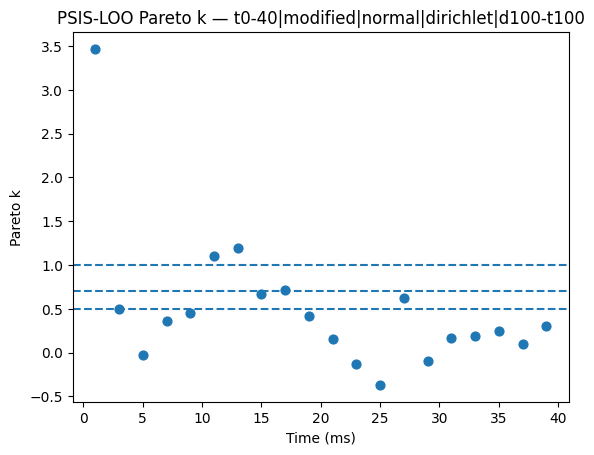

In [ ]:
pk = pd.read_csv(f"sweep_results/pareto_k_{best.label}.csv")  # saved by the sweep

plt.figure()
plt.scatter(pk["x"], pk["pareto_k"], s=40)
for th in (0.5, 0.7, 1.0):
    plt.axhline(th, ls="--")
plt.xlabel("Time (ms)"); plt.ylabel("Pareto k")
plt.title(f"PSIS-LOO Pareto k — {best.label}")
plt.show()


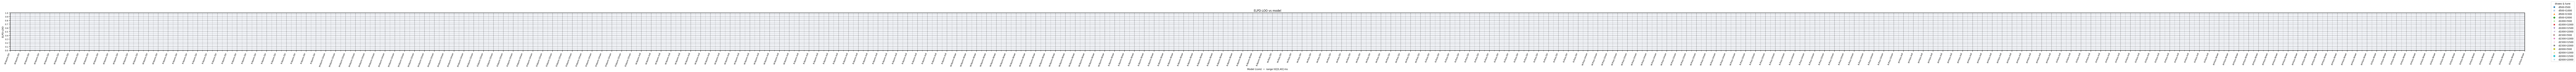

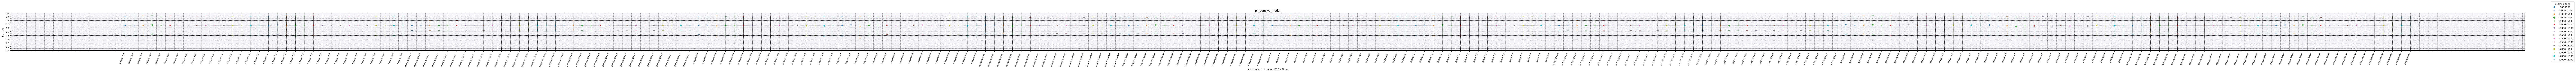

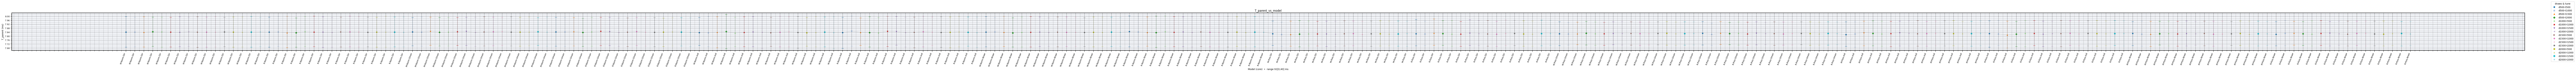

In [1]:
# %% 2D scatter plots for MULTIPLE RANGES
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, AutoMinorLocator, MultipleLocator

# ---------------- CONFIG ----------------
SAVE_DIR = "sweep_results"
# Set to None to auto-detect all ranges present in metrics_df
#RANGES = None
# Or explicitly choose ranges, e.g.:
RANGES = [(0, 40)]

# Visual style
LINE_W, ELINE_W   = 0.7, 0.7
CAPSIZE, CAPTHICK = 4, 1.0
MARKER_SIZE       = 5
TICK_FONTSZ       = 9
LABEL_ROT         = 70

# High-contrast grid
FACE_COLOR  = "#f2f4f8"
MAJOR_COLOR = "#222222"
MINOR_COLOR = "#222222"
MAJOR_LW    = 0.7
MINOR_LW    = 0.7
MAJOR_A     = 1.0
MINOR_A     = 0.9
GRID_ON_TOP = True

os.makedirs(SAVE_DIR, exist_ok=True)

# path to where you saved it
csv_path = os.path.join("sweep_results", "metrics.csv")

# read it back
metrics_df = pd.read_csv(csv_path)
# ------------- Axes styler -------------
def apply_axes_style(ax):
    ax.set_facecolor(FACE_COLOR)
    for s in ax.spines.values():
        s.set_linewidth(1.6)
    ax.tick_params(axis="both", width=1.2, length=5, which="major", labelsize=TICK_FONTSZ)
    ax.tick_params(axis="both", width=1.0, length=3, which="minor")
    if not isinstance(ax.xaxis.get_minor_locator(), AutoMinorLocator):
        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    if not isinstance(ax.yaxis.get_minor_locator(), AutoMinorLocator):
        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.set_axisbelow(not GRID_ON_TOP)
    ax.grid(True, which="major", axis="both",
            color=MAJOR_COLOR, linestyle="--", linewidth=MAJOR_LW, alpha=MAJOR_A)
    ax.grid(True, which="minor", axis="both",
            color=MINOR_COLOR, linestyle=":",  linewidth=MINOR_LW, alpha=MINOR_A)
    if GRID_ON_TOP:
        for ln in ax.get_xgridlines() + ax.get_ygridlines():
            ln.set_zorder(10)

# -------- Helpers: posterior parquet parsing --------
def _sample_index_cols(df):
    if "sample" in df.columns: return ["sample"]
    if {"chain","draw"}.issubset(df.columns): return ["chain","draw"]
    return []

def _groupby_samples(df):
    idx = _sample_index_cols(df)
    if idx: return df.groupby(idx, sort=False)
    df2 = df.copy(); df2["_row"] = np.arange(len(df2))
    return df2.groupby("_row", sort=False)

def scalar_samples(df, var):
    if var not in df.columns: return None
    cols = _sample_index_cols(df) + [var] if _sample_index_cols(df) else [var]
    sub = df[cols].dropna()
    if sub.empty: return None
    return _groupby_samples(sub)[var].first().values

def _find_dim_col(df, var):
    for c in df.columns:
        if c.startswith(f"{var}_dim"): return c
    for c in df.columns:
        if c.startswith("dim_"): return c
    return None

def vector_component_samples(df, var, i):
    dim_col = _find_dim_col(df, var)
    if dim_col is None or var not in df.columns: return None
    cols = _sample_index_cols(df) + [var] if _sample_index_cols(df) else [var]
    sub = df[df[dim_col] == i][cols].dropna()
    if sub.empty: return None
    return _groupby_samples(sub)[var].first().values

def q16_50_84(x): return np.quantile(x, [0.16, 0.50, 0.84])

# -------- Model core label (compact) --------
abbr = {
    "modified":"M", "regular":"R",
    "poisson":"Pois", "normal":"Norm", "negbin":"NB",
    "dirichlet":"Dir", "softmax":"Smax", "independent":"Ind", "normalized_raw":"Nraw",
}
def core_name(row):
    return f"{abbr.get(row['model_type'],row['model_type'])}-" \
           f"{abbr.get(row['likelihood'],row['likelihood'])}-" \
           f"{abbr.get(row['branching_mode'],row['branching_mode'])}"

# -------- Prep metrics & ranges --------
mdf_all = metrics_df.copy()
mdf_all = mdf_all[mdf_all["error"].isna()].reset_index(drop=True)
if mdf_all.empty:
    raise ValueError("No successful runs found in metrics_df.")

if RANGES is None:
    RANGES = sorted({(int(r.tmin), int(r.tmax)) for _, r in mdf_all.iterrows()})

# Build a consistent style map for ALL (draws,tune) pairs present in the selected ranges
subset_for_styles = pd.concat(
    [mdf_all[(mdf_all["tmin"]==t0) & (mdf_all["tmax"]==t1)] for (t0,t1) in RANGES],
    ignore_index=True,
)
pairs = list(dict.fromkeys([(int(d), int(t)) for d, t in zip(subset_for_styles["draws"], subset_for_styles["tune"])]))
cmap = plt.cm.get_cmap("tab20", max(4, len(pairs)))
markers = ["o","s","^","D","P","X","v","<",">","h","*"]
pair2style = {p: dict(color=cmap(i % cmap.N), marker=markers[i % len(markers)], label=f"d{p[0]}-t{p[1]}")
              for i, p in enumerate(pairs)}

# -------- Per-range plotting function --------
def plot_for_range(t0, t1):
    mdf = mdf_all[(mdf_all["tmin"]==t0) & (mdf_all["tmax"]==t1)].copy()
    if mdf.empty:
        print(f"[{t0},{t1}] no runs; skipping.")
        return
    # Build summary
    rows = []
    for _, r in mdf.iterrows():
        elpd    = float(r["elpd_loo"]) if "elpd_loo" in r and pd.notna(r["elpd_loo"]) else np.nan
        elpd_se = float(r["loo_se"])    if "loo_se"    in r and pd.notna(r["loo_se"])    else np.nan
        bsum_mean = np.nan; bsum_q16 = np.nan; bsum_q84 = np.nan
        T_med = np.nan; T_q16 = np.nan; T_q84 = np.nan
        try:
            post = pd.read_parquet(r["posterior_path"])
            b1 = vector_component_samples(post, "b", 1)
            b2 = vector_component_samples(post, "b", 2)
            if b1 is not None and b2 is not None and len(b1)==len(b2):
                bsum = b1 + b2
                bsum_q16, bsum_med, bsum_q84 = q16_50_84(bsum)
                bsum_mean = float(np.mean(bsum))
            tp = scalar_samples(post, "T_parent")
            if tp is not None and len(tp):
                T_q16, T_med, T_q84 = q16_50_84(tp)
                T_q16, T_med, T_q84 = float(T_q16), float(T_med), float(T_q84)
        except Exception:
            pass
        rows.append(dict(
            model_core = core_name(r),
            draws      = int(r["draws"]),
            tune       = int(r["tune"]),
            elpd_loo   = elpd, elpd_se = elpd_se,
            bsum_mean  = bsum_mean, bsum_q16 = bsum_q16, bsum_q84 = bsum_q84,
            T_med      = T_med, T_q16 = T_q16, T_q84 = T_q84,
        ))
    summary = pd.DataFrame(rows).sort_values("elpd_loo", ascending=True).reset_index(drop=True)
    x = np.arange(len(summary))
    labels_core = summary["model_core"].tolist()
    fig_w = max(10, 0.6*len(x))

    # --- Plot 1: ELPD-LOO ---
    fig, ax = plt.subplots(figsize=(fig_w, 4))
    finite_idx = np.where(np.isfinite(summary["elpd_loo"]))[0]
    if finite_idx.size:
        for i in range(len(summary)):
            y = summary.loc[i, "elpd_loo"]
            if not np.isfinite(y): 
                continue
            se = 0 if pd.isna(summary.loc[i, "elpd_se"]) else summary.loc[i, "elpd_se"]
            sty = pair2style[(summary.loc[i,"draws"], summary.loc[i,"tune"])]
            ax.errorbar([i], [y], yerr=[[se],[se]],
                        fmt=sty["marker"], color=sty["color"],
                        ms=MARKER_SIZE, capsize=CAPSIZE, capthick=CAPTHICK, elinewidth=ELINE_W)
        ax.plot(finite_idx, summary.loc[finite_idx, "elpd_loo"], "-", lw=LINE_W, alpha=0.4, color="#777")
    ax.set_xticks(x); ax.set_xticklabels(labels_core, rotation=LABEL_ROT, ha="right", fontsize=TICK_FONTSZ)
    ax.set_xlabel(f"Model (core)  •  range t∈[{t0},{t1}] ms"); ax.set_ylabel("ELPD-LOO"); ax.set_title("ELPD-LOO vs model")
    ax.yaxis.set_major_locator(MaxNLocator(10)); ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    handles = [plt.Line2D([0],[0], marker=sty["marker"], color=sty["color"], lw=0, label=sty["label"])
               for _, sty in pair2style.items()]
    ax.legend(handles=handles, title="draws & tune", loc="center left", bbox_to_anchor=(1.01, 0.5))
    apply_axes_style(ax)
    fig.tight_layout(); fig.savefig(os.path.join(SAVE_DIR, f"ELPD_LOO_vs_model_scatter_t{t0}-{t1}.png"), dpi=150)
    plt.show()

    # --- Plot 2: pn_sum_vs_model (b1n+b2n) ---
    mask_b = summary["bsum_mean"].notna()
    if mask_b.any():
        fig, ax = plt.subplots(figsize=(fig_w, 4))
        for i in range(len(summary)):
            if not mask_b.iloc[i]: 
                continue
            y  = summary.loc[i, "bsum_mean"]; lo = summary.loc[i, "bsum_q16"]; hi = summary.loc[i, "bsum_q84"]
            if not np.isfinite(y): 
                continue
            yerr = np.vstack([np.clip(y - lo, 0, None), np.clip(hi - y, 0, None)])
            sty = pair2style[(summary.loc[i,"draws"], summary.loc[i,"tune"])]
            ax.errorbar([i], [y], yerr=yerr, fmt=sty["marker"], color=sty["color"],
                        ms=MARKER_SIZE, capsize=CAPSIZE, capthick=CAPTHICK, elinewidth=ELINE_W)
        xs = summary.index[mask_b & np.isfinite(summary["bsum_mean"])]
        ax.plot(xs, summary.loc[xs, "bsum_mean"], "-", lw=LINE_W, alpha=0.4, color="#777")
        ax.set_ylim(0, 1)
        ax.set_xticks(x); ax.set_xticklabels(labels_core, rotation=LABEL_ROT, ha="right", fontsize=TICK_FONTSZ)
        ax.set_xlabel(f"Model (core)  •  range t∈[{t0},{t1}] ms"); ax.set_ylabel(r"$b_{1n}+b_{2n}$"); ax.set_title("pn_sum_vs_model")
        ax.yaxis.set_major_locator(MultipleLocator(0.1)); ax.yaxis.set_minor_locator(MultipleLocator(0.05))
        ax.legend(handles=handles, title="draws & tune", loc="center left", bbox_to_anchor=(1.01, 0.5))
        apply_axes_style(ax)
        fig.tight_layout(); fig.savefig(os.path.join(SAVE_DIR, f"pn_sum_vs_model_scatter_t{t0}-{t1}.png"), dpi=150)
        plt.show()
    else:
        print(f"[{t0},{t1}] pn_sum_vs_model: no branching components available (need b[1] & b[2]).")

    # --- Plot 3: T_parent_vs_model ---
    mask_t = summary["T_med"].notna()
    if mask_t.any():
        fig, ax = plt.subplots(figsize=(fig_w, 4))
        for i in range(len(summary)):
            if not mask_t.iloc[i]: 
                continue
            y  = summary.loc[i, "T_med"]; lo = summary.loc[i, "T_q16"]; hi = summary.loc[i, "T_q84"]
            if not np.isfinite(y): 
                continue
            yerr = np.vstack([np.clip(y - lo, 0, None), np.clip(hi - y, 0, None)])
            sty = pair2style[(summary.loc[i,"draws"], summary.loc[i,"tune"])]
            ax.errorbar([i], [y], yerr=yerr, fmt=sty["marker"], color=sty["color"],
                        ms=MARKER_SIZE, capsize=CAPSIZE, capthick=CAPTHICK, elinewidth=ELINE_W)
        xs = summary.index[mask_t & np.isfinite(summary["T_med"])]
        ax.plot(xs, summary.loc[xs, "T_med"], "-", lw=LINE_W, alpha=0.4, color="#777")
        ax.set_xticks(x); ax.set_xticklabels(labels_core, rotation=LABEL_ROT, ha="right", fontsize=TICK_FONTSZ)
        ax.set_xlabel(f"Model (core)  •  range t∈[{t0},{t1}] ms"); ax.set_ylabel("T_parent (ms)"); ax.set_title("T_parent_vs_model")
        ax.yaxis.set_major_locator(MaxNLocator(10)); ax.yaxis.set_minor_locator(AutoMinorLocator(2))
        ax.legend(handles=handles, title="draws & tune", loc="center left", bbox_to_anchor=(1.01, 0.5))
        apply_axes_style(ax)
        fig.tight_layout(); fig.savefig(os.path.join(SAVE_DIR, f"T_parent_vs_model_scatter_t{t0}-{t1}.png"), dpi=150)
        plt.show()
    else:
        print(f"[{t0},{t1}] T_parent_vs_model: no T_parent found in parquet.")

# -------- Run for each requested range --------
for (t0, t1) in RANGES:
    plot_for_range(t0, t1)


In [2]:
def summarize(var, s):
    qs = np.quantile(s, [0.16, 0.5, 0.84])
    print(f"{var:10s}: {qs[1]:.4g}  [{qs[0]:.4g}, {qs[2]:.4g}]")

for var in vars_present:
    s = scalar_samples(post, var)
    if s is not None and len(s):
        summarize(var, s)


NameError: name 'vars_present' is not defined

In [3]:
# %% Find model closest to targets: T_parent ≈ 8.2, (b1+b2) ≈ 0.6
import os, numpy as np, pandas as pd

TARGET_T   = 8.2     # ms
TARGET_P   = 0.60    # p1n + p2n
RANGE      = None    # e.g., (0,40) to constrain by time window; or None for all
TOP_K      = 5       # how many best to show

# ---------- 1) Get a summary table with T_parent & (b1+b2) ----------
def _have_summary_in_memory():
    return "summary" in globals() and isinstance(summary, pd.DataFrame)

def _load_summary_csv():
    path = "sweep_results/summary_with_posteriors.csv"
    return pd.read_csv(path) if os.path.exists(path) else None

def _sample_index_cols(df):
    if "sample" in df.columns: return ["sample"]
    if {"chain","draw"}.issubset(df.columns): return ["chain","draw"]
    return []

def _groupby_samples(df):
    idx = _sample_index_cols(df)
    if idx: return df.groupby(idx, sort=False)
    df2 = df.copy(); df2["_row"] = np.arange(len(df2))
    return df2.groupby("_row", sort=False)

def _scalar_samples(df, var):
    if var not in df.columns: return None
    cols = _sample_index_cols(df) + [var] if _sample_index_cols(df) else [var]
    sub = df[cols].dropna()
    if sub.empty: return None
    return _groupby_samples(sub)[var].first().values

def _find_dim_col(df, var):
    for c in df.columns:
        if c.startswith(f"{var}_dim"): return c
    for c in df.columns:
        if c.startswith("dim_"): return c
    return None

def _vector_component_samples(df, var, i):
    dim_col = _find_dim_col(df, var)
    if dim_col is None or var not in df.columns: return None
    cols = _sample_index_cols(df) + [var] if _sample_index_cols(df) else [var]
    sub = df[df[dim_col] == i][cols].dropna()
    if sub.empty: return None
    return _groupby_samples(sub)[var].first().values

def _q16_50_84(x): return np.quantile(x, [0.16, 0.50, 0.84])

def build_summary_from_metrics(metrics_df):
    rows = []
    mdf = metrics_df.copy()
    mdf = mdf[mdf["error"].isna()].reset_index(drop=True)
    for _, r in mdf.iterrows():
        try:
            post = pd.read_parquet(r["posterior_path"])
        except Exception:
            # keep NaNs if parquet missing
            post = None

        # defaults
        T_q16 = T_med = T_q84 = np.nan
        bsum_q16 = bsum_mean = bsum_q84 = np.nan

        if post is not None:
            # T_parent
            tp = _scalar_samples(post, "T_parent")
            if tp is not None and len(tp):
                tq16, tmed, tq84 = _q16_50_84(tp)
                T_q16, T_med, T_q84 = float(tq16), float(tmed), float(tq84)
            # b1+b2
            b1 = _vector_component_samples(post, "b", 1)
            b2 = _vector_component_samples(post, "b", 2)
            if b1 is not None and b2 is not None and len(b1)==len(b2):
                bsum = b1 + b2
                bq16, bmed, bq84 = _q16_50_84(bsum)
                bsum_q16, bsum_mean, bsum_q84 = float(bq16), float(np.mean(bsum)), float(bq84)

        rows.append(dict(
            label=r.get("label", ""),
            tmin=float(r.get("tmin", np.nan)),
            tmax=float(r.get("tmax", np.nan)),
            model_type=r.get("model_type",""),
            likelihood=r.get("likelihood",""),
            branching_mode=r.get("branching_mode",""),
            draws=int(r.get("draws", np.nan)) if pd.notna(r.get("draws", np.nan)) else np.nan,
            tune=int(r.get("tune", np.nan)) if pd.notna(r.get("tune", np.nan)) else np.nan,
            elpd_loo=float(r.get("elpd_loo", np.nan)) if pd.notna(r.get("elpd_loo", np.nan)) else np.nan,
            T_parent_q16=T_q16, T_parent_med=T_med, T_parent_q84=T_q84,
            bsum_q16=bsum_q16, bsum_mean=bsum_mean, bsum_q84=bsum_q84,
            posterior_path=r.get("posterior_path", None),
            ppc_summary_path=r.get("ppc_summary_path", None),
        ))
    return pd.DataFrame(rows)

# assemble df_summary
if _have_summary_in_memory():
    df_summary = summary.copy()
else:
    df_summary = _load_summary_csv()
    if df_summary is None:
        # fall back: build minimal summary from metrics_df
        if "metrics_df" not in globals():
            raise RuntimeError("No 'summary' in memory and no CSV; please define metrics_df or run the sweep first.")
        df_summary = build_summary_from_metrics(metrics_df)

# Normalize column names for T and bsum
T_med_col  = "T_med" if "T_med" in df_summary.columns else ("T_parent_med" if "T_parent_med" in df_summary.columns else None)
T_q16_col  = "T_q16" if "T_q16" in df_summary.columns else ("T_parent_q16" if "T_parent_q16" in df_summary.columns else None)
T_q84_col  = "T_q84" if "T_q84" in df_summary.columns else ("T_parent_q84" if "T_parent_q84" in df_summary.columns else None)
if T_med_col is None: raise RuntimeError("No T_parent summary found in the data (need median column).")
if "bsum_mean" not in df_summary.columns: raise RuntimeError("No (b1+b2) summary found in the data.")

# Optional: filter by time range
if RANGE is not None and {"tmin","tmax"}.issubset(df_summary.columns):
    df_summary = df_summary[(df_summary["tmin"]==RANGE[0]) & (df_summary["tmax"]==RANGE[1])].copy()

# Keep only rows with needed stats
dfc = df_summary[df_summary[T_med_col].notna() & df_summary["bsum_mean"].notna()].copy()
if dfc.empty:
    raise RuntimeError("No runs contain both T_parent and (b1+b2).")

# ---------- 2) Compute closeness ----------
dfc["err_T"]  = (dfc[T_med_col] - TARGET_T).abs()
dfc["err_p"]  = (dfc["bsum_mean"] - TARGET_P).abs()
dfc["err_L2"] = np.sqrt(dfc["err_T"]**2 + dfc["err_p"]**2)
dfc["err_max"] = np.maximum(dfc["err_T"], dfc["err_p"])

# standardized error (optional; only if quantiles exist)
if T_q16_col in dfc.columns and T_q84_col in dfc.columns and {"bsum_q16","bsum_q84"}.issubset(dfc.columns):
    T_hw  = 0.5*(dfc[T_q84_col] - dfc[T_q16_col]).replace(0, np.nan)
    p_hw  = 0.5*(dfc["bsum_q84"] - dfc["bsum_q16"]).replace(0, np.nan)
    dfc["z_T"]  = dfc["err_T"] / T_hw
    dfc["z_p"]  = dfc["err_p"] / p_hw
    dfc["err_zL2"] = np.sqrt(dfc["z_T"]**2 + dfc["z_p"]**2)
else:
    dfc["err_zL2"] = np.nan

# ---------- 3) Report best matches ----------
cols_basic = ["label","model_type","likelihood","branching_mode","draws","tune",
              "elpd_loo", T_med_col, "bsum_mean","err_T","err_p","err_L2","err_zL2"]
cols_basic = [c for c in cols_basic if c in dfc.columns]

best_L2 = dfc.sort_values("err_L2", ascending=True).head(TOP_K)[cols_basic]
print(f"\nTop {TOP_K} by absolute L2 distance to (T={TARGET_T}, p_sum={TARGET_P}):")
display(best_L2.reset_index(drop=True))

if dfc["err_zL2"].notna().any():
    best_zL2 = dfc.sort_values("err_zL2", ascending=True).head(TOP_K)[cols_basic]
    print(f"\nTop {TOP_K} by standardized L2 (uses 68% bands if available):")
    display(best_zL2.reset_index(drop=True))

# The single closest run (absolute L2):
best_row = dfc.loc[dfc["err_L2"].idxmin()]
print("\nBest (absolute L2):")
print(f"  label: {best_row.get('label','')}")
print(f"  model: {best_row.get('model_type','')} | {best_row.get('likelihood','')} | {best_row.get('branching_mode','')}")
print(f"  draws/tune: d{int(best_row.get('draws'))}-t{int(best_row.get('tune'))}")
print(f"  ELPD-LOO: {best_row.get('elpd_loo', np.nan):.3f}")
print(f"  T_parent: {best_row[T_med_col]:.3g}  (target {TARGET_T})")
print(f"  p1n+p2n:  {best_row['bsum_mean']:.3g}  (target {TARGET_P})")
print(f"  L2 error: {best_row['err_L2']:.4g}")



Top 5 by absolute L2 distance to (T=8.2, p_sum=0.6):


,label,model_type,likelihood,branching_mode,draws,tune,elpd_loo,T_parent_med,bsum_mean,err_T,err_p,err_L2,err_zL2
0,t0-40|modified|normal|dirichlet|d100-t100,modified,normal,dirichlet,100,100,NaN,7.816015,0.669137,0.383985,0.069137,0.390159,2.038776
1,t0-40|modified|poisson|dirichlet|d100-t100,modified,poisson,dirichlet,100,100,NaN,7.822555,0.736298,0.377445,0.136298,0.401300,0.955169



Top 5 by standardized L2 (uses 68% bands if available):


,label,model_type,likelihood,branching_mode,draws,tune,elpd_loo,T_parent_med,bsum_mean,err_T,err_p,err_L2,err_zL2
0,t0-40|modified|poisson|dirichlet|d100-t100,modified,poisson,dirichlet,100,100,NaN,7.822555,0.736298,0.377445,0.136298,0.401300,0.955169
1,t0-40|modified|normal|dirichlet|d100-t100,modified,normal,dirichlet,100,100,NaN,7.816015,0.669137,0.383985,0.069137,0.390159,2.038776



Best (absolute L2):
  label: t0-40|modified|normal|dirichlet|d100-t100
  model: modified | normal | dirichlet
  draws/tune: d100-t100
  ELPD-LOO: nan
  T_parent: 7.82  (target 8.2)
  p1n+p2n:  0.669  (target 0.6)
  L2 error: 0.3902
